In [1]:
import _init_paths
from datasets.dataset_factory import get_dataset
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torch.utils.data
import numpy as np

In [2]:
data=get_dataset('wider_csp','fadet')

In [20]:
val_loader = torch.utils.data.DataLoader(
        data(mode='train'),
        batch_size=1,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        # collate_fn=default_collate
    )
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)

num_imgs: 12876


In [88]:
import torch.nn as nn
from torch.nn.parameter import Parameter
from torchvision.models.utils import load_state_dict_from_url
import torch.nn.functional as F
import torch
import os.path as osp
import math
__all__ = [
    'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'resnext50_32x4d', 'resnext101_32x8d'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34':
    'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101':
    'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152':
    'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d':
    'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d':
    'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
}


def group_norm(in_planes):
    return nn.GroupNorm(in_planes // 16, in_planes)


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv4x4(in_planes, out_planes, stride=1, groups=1, dilation=1, padding=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=4,
                     stride=stride,
                     padding=padding,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv2x2(in_planes, out_planes, stride=1, groups=1, dilation=1, padding=0):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=2,
                     stride=stride,
                     padding=padding,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class L2Norm(nn.Module):
    def __init__(self, inplanes, gamma_init=10):
        super(L2Norm, self).__init__()
        self.gamma_init = torch.Tensor(1, inplanes, 1, 1)
        self.gamma_init[...] = gamma_init
        self.gamma_init = Parameter(self.gamma_init)

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        x = x * self.gamma_init
        return x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None,
                 replace_with_bn=False,
                 layer_conv=False,layer4=False):
        super(BasicBlock, self).__init__()
        self.norm_layer = norm_layer
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        # if dilation > 1:
        #     raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        if layer4:
            layer_conv=dict(k=4,p=3,s=1,d=2)
        if layer_conv :
            self.conv1 = nn.Conv2d(inplanes,
                                   planes,
                                   kernel_size=layer_conv['k'],
                                   stride=layer_conv['s'],
                                   padding=layer_conv['p'],
                                   groups=groups,
                                   bias=False,
                                   dilation=layer_conv['d'])
        else:
            self.conv1 = conv3x3(inplanes, planes, stride, dilation=dilation)
        if replace_with_bn:
            norm_layer = group_norm
        self.bn1 = norm_layer(planes)
        norm_layer = self.norm_layer
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None,
                 conv4=False,
                 conv2=False,
                 replace_with_bn=False):
        super(Bottleneck, self).__init__()
        self.norm_layer = norm_layer
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        if conv4 and dilation == 1:
            self.conv2 = conv4x4(width, width, stride, groups)
        elif conv2 and dilation == 1:
            self.conv2 = conv2x2(width, width, stride, groups)
        elif dilation > 1:
            self.conv1 = conv4x4(inplanes, planes, stride,
                                 dilation=dilation, padding=3)
        else:
            self.conv1 = conv3x3(in_planes, out_planes)
        if replace_with_bn:
            norm_layer = group_norm
        self.bn2 = norm_layer(width)
        norm_layer = self.norm_layer
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self,
                 block,
                 layers,
                 layer_conf=dict(),
                 num_classes=1000,
                 zero_init_residual=False,
                 groups=1,
                 width_per_group=64,
                 replace_stride_with_dilation=None,
                 norm_layer=None,
                 change_s1=False,
                 replace_with_bn=False,
                 all_gn=False, mask_layer=False):
        super(ResNet, self).__init__()
        self.layer_conf = dict(
            layer0=dict(conv=dict(k=4,p=1,d=1,s=2),down=dict(k=2, p=0, d=1, s=2)),
            layer1=dict(conv=dict(k=4,p=1,d=1,s=2),
            down=dict(k=2, p=0, d=1, s=2)),
            layer2=dict(conv=dict(k=4, p=1, d=1, s=2),
                        down=dict(k=2, p=0, d=1, s=2)),
            layer3=dict(conv=dict(k=4, p=1, d=1, s=2),
                        down=dict(k=2, p=0, d=1, s=2)),
            layer4=dict(conv=dict(k=3, p=2, d=2, s=1),
                        down=dict(k=1, p=0, d=1, s=1)))
        print(self.layer_conf)
        self.layer_conf.update(layer_conf)
        layer_conf = self.layer_conf
        if all_gn:
            bn_layer = group_norm
        else:
            bn_layer = nn.BatchNorm2d
        print(all_gn)
        print(bn_layer)
        input('s')

        norm_layer = bn_layer
        self._norm_layer = norm_layer

        if block is BasicBlock:
            transform_planes = 128
        elif block is Bottleneck:
            transform_planes = 256
        else:
            raise ValueError('not block')
        self.inplanes = 64
        self.dilation = 1
        self.change_s1 = change_s1
        self.groups = groups
        self.base_width = width_per_group
        if change_s1:
            if replace_with_bn:
                norm_layer = group_norm
            self.inplanes = 16
            self.layeri0 = nn.Sequential(
                nn.Conv2d(3,
                          16,
                          kernel_size=3,
                          stride=1,
                          padding=1,
                          bias=False), norm_layer(self.inplanes),
                nn.ReLU(inplace=True))
            self.layeri1 = self._make_layer(block,
                                            16,
                                            1,
                                            stride=1,
                                            )
            self.layer0 = self._make_layer(block,
                                           32,
                                           2,
                                           stride=2,
                                           layer_conf=layer_conf['layer0']
                                           )
            norm_layer = self._norm_layer
            self.layer1 = self._make_layer(block,
                                           64,
                                           layers[0],
                                           stride=2,
                                           layer_conf=layer_conf['layer1']

                                           )
        else:
            self.conv1 = nn.Conv2d(3,
                                   self.inplanes,
                                   kernel_size=7,
                                   stride=2,
                                   padding=3,
                                   bias=False)
            self.bn1 = norm_layer(self.inplanes)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.layer1 = self._make_layer(block,
                                           64,
                                           layers[0],
                                           stride=1,

                                           )
        self.inplanes_s2 = self.inplanes
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       layer_conf=layer_conf['layer2']
                                       )
        self.inplanes_s3 = self.inplanes
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       layer_conf=layer_conf['layer3']

                                       )
        self.inplanes_s4 = self.inplanes
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       layer_conf=layer_conf['layer4'],layer4=True)
        self.inplanes_s5 = self.inplanes
        self.s3_up = nn.ConvTranspose2d(in_channels=self.inplanes_s3,
                                        out_channels=transform_planes,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1,
                                        output_padding=0,
                                        bias=False)
        self.s4_up = nn.ConvTranspose2d(in_channels=self.inplanes_s4,
                                        out_channels=transform_planes,
                                        kernel_size=4,
                                        stride=4,
                                        padding=0,
                                        output_padding=0,
                                        bias=False)
        self.s5_up = nn.ConvTranspose2d(in_channels=self.inplanes_s5,
                                        out_channels=transform_planes,
                                        kernel_size=4,
                                        stride=4,
                                        padding=0,
                                        output_padding=0,
                                        bias=False)
        self.n3 = L2Norm(transform_planes)
        self.n4 = L2Norm(transform_planes)
        self.n5 = L2Norm(transform_planes)
        self.s_conv = nn.Sequential(
            nn.Conv2d(in_channels=transform_planes * 3,
                      out_channels=transform_planes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False), norm_layer(transform_planes),
            nn.ReLU(inplace=True))
        self.hm = nn.Sequential(
            nn.Conv2d(
                in_channels=transform_planes,
                out_channels=1,
                kernel_size=1,
                stride=1,
                padding=0,
            ), nn.Sigmoid())
        self.wh = nn.Sequential(
            nn.Conv2d(
                in_channels=transform_planes,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=0,
            ))
        self.offset = nn.Sequential(
            nn.Conv2d(
                in_channels=transform_planes,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=0,
            ))
        self.mask_layer = mask_layer
        if mask_layer:
            self.mask = nn.Sequential(
                nn.Conv2d(
                    in_channels=transform_planes,
                    out_channels=1,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                ), nn.Sigmoid())
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #     elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, Bottleneck):
        #             nn.init.constant_(m.bn3.weight, 0)
        #         elif isinstance(m, BasicBlock):
        #             nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self,
                    block,
                    planes,
                    blocks,
                    stride=1,
                    replace_with_bn=False,
                    layer_conf=dict(conv=dict(k=3, p=1, s=1, d=1), down=dict(k=1, p=0, s=1, d=1)),layer4=False):
        down = layer_conf['down']
        conv = layer_conf['conv']
        norm_layer = self._norm_layer
        downsample = None
        self.dilation = conv['d']
        if stride != 1 or self.inplanes != planes * block.expansion:
            if replace_with_bn:
                norm_layer = group_norm
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes,
                          planes * block.expansion,
                          kernel_size=down['k'],
                          stride=down['s'],
                          padding=down['p'],
                          bias=False,
                          dilation=down['d']),
                norm_layer(planes * block.expansion),
            )
            norm_layer = self._norm_layer
        layers = []
        layers.append(
            block(self.inplanes,
                  planes,
                  stride,
                  downsample,
                  self.groups,
                  self.base_width,
                  norm_layer=norm_layer,
                  layer_conv=conv,
                  replace_with_bn=replace_with_bn))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation,
                      norm_layer=norm_layer,layer4=layer4))

        return nn.Sequential(*layers)

    def forward(self, x):
        if self.change_s1:
            x = self.layeri0(x)
            x = self.layeri1(x)
            x = self.layer0(x)
            s2 = self.layer1(x)
        else:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            s2 = self.layer1(x)
        s3 = self.layer2(s2)
        s4 = self.layer3(s3)
        s5 = self.layer4(s4)
        s3 = self.s3_up(s3)
        s4 = self.s4_up(s4)
        s5 = self.s5_up(s5)
        s3 = self.n3(s3)
        s4 = self.n4(s4)
        s5 = self.n5(s5)
        s_cat = torch.cat([s3, s4, s5], 1)
        s_cat = self.s_conv(s_cat)
        hm = self.hm(s_cat)
        wh = self.wh(s_cat)
        offset = self.offset(s_cat)
        return_data = dict(hm=hm, wh=wh, offset=offset)
        if self.mask_layer:
            mask = self.mask(s_cat)
            return_data['mask'] = mask
        return return_data

    def init_weights(
            self,
            pretrained='',
    ):
        if osp.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            if 'state_dict' in pretrained_dict.keys():
                pretrained_dict = pretrained_dict['state_dict']
            elif 'model' in pretrained_dict.keys():
                pretrained_dict = pretrained_dict['model']
                new_dict = dict()
                for k, v in pretrained_dict.items():
                    new_dict[k[7:]] = v
                pretrained_dict = new_dict
        elif pretrained:
            pretrained_dict = load_state_dict_from_url(
                model_urls[pretrained], map_location='cpu')
            # self.load_state_dict(pretrained_dict)
        model_dict = self.state_dict()
        if pretrained:
            pretrained_dict = {
                k: v
                for k, v in pretrained_dict.items()
                # and 'bn' not in k
                if k in model_dict.keys() and v.shape == model_dict[k].shape
            }
            # for k,v in self.named_parameters():
            #     v.requires_grad=False
            #     if 'layer2' in k:
            #         break
        else:
            pretrained_dict = self.state_dict()
        # for k,v in self.named_parameters():
        #     if 'bn' in k:
        #         v.requires_grad=False
        for k, v in self.named_parameters():
            if 'hm' in k:
                if 'bias' in k:
                    pretrained_dict[k] = torch.ones_like(v) * -math.log(
                        (1 - 0.01) / 0.01)
            print(k, v.requires_grad)
        input('grad:')
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        for k, v in self.named_parameters():
            print(k, v.shape)
        input('model_parameters:')
        for k, v in pretrained_dict.items():
            print(k, v.shape)
        input('pretrained_parameters')


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    print(kwargs)
    input('s')
    if pretrained:
        model.init_weights(pretrained=arch)
    print(model)
    input('s')
    return model


def resnet18(pretrained=True, progress=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18',
                   BasicBlock, [2, 2, 2, 2],
                   pretrained,
                   progress,
                   replace_stride_with_dilation=[True, False, True],
                   **kwargs)


def resnet50(pretrained=True, progress=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50',
                   Bottleneck, [3, 4, 6, 3],
                   pretrained,
                   progress,
                   replace_stride_with_dilation=[True, False, True],
                   **kwargs)


def test():
    import torch
    net = resnet18(layer_conf=dict())
    for k, v in net.named_parameters():
        print(k)
    print(net)
    a = torch.ones(1, 3, 255, 255)
    b = net(a)
    for name, output in b.items():
        print(name, output.shape)
    input('s')


# if __name__ == "__main__":
#     test()


In [5]:
import torch.nn as nn
from torch.nn.parameter import Parameter
from torchvision.models.utils import load_state_dict_from_url
import torch.nn.functional as F
import torch
import os.path as osp
import math
__all__ = [
    'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'resnext50_32x4d', 'resnext101_32x8d'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34':
    'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101':
    'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152':
    'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d':
    'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d':
    'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
}


def group_norm(in_planes):
    return nn.GroupNorm(in_planes // 16, in_planes)


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv4x4(in_planes, out_planes, stride=1, groups=1, dilation=1, padding=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=4,
                     stride=stride,
                     padding=padding,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv2x2(in_planes, out_planes, stride=1, groups=1, dilation=1, padding=0):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=2,
                     stride=stride,
                     padding=padding,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class L2Norm(nn.Module):
    def __init__(self, inplanes, gamma_init=10):
        super(L2Norm, self).__init__()
        self.gamma_init = torch.Tensor(1, inplanes, 1, 1)
        self.gamma_init[...] = gamma_init
        self.gamma_init = Parameter(self.gamma_init)

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        x = x * self.gamma_init
        return x


class InceptionBlock(nn.Module):
    def __init__(self, multi_large=False,):
        super(InceptionBlock, self).__init__()
        self.multi_large = multi_large

        self.convs = nn.ModuleList(
            [nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1, stride=1, padding=0, bias=False),
             nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,
                       stride=1, padding=1, bias=False),
             nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5,
                       stride=1, padding=2, bias=False),
             nn.Conv2d(in_channels=16, out_channels=3, kernel_size=7, stride=1, padding=3, bias=False)]
        )

    def forward(self, x):
        output = []
        for conv_module in self.convs:
            output.append(conv_module(x))
        x = torch.cat(output, 1)
        return x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None,
                 replace_with_bn=False,
                 layer_conv=False, layer4=False):
        super(BasicBlock, self).__init__()
        self.norm_layer = norm_layer
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        # if dilation > 1:
        #     raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        if layer4:
            layer_conv = dict(k=4, p=3, s=1, d=2)
        if layer_conv:
            self.conv1 = nn.Conv2d(inplanes,
                                   planes,
                                   kernel_size=layer_conv['k'],
                                   stride=layer_conv['s'],
                                   padding=layer_conv['p'],
                                   groups=groups,
                                   bias=False,
                                   dilation=layer_conv['d'])
        else:
            self.conv1 = conv3x3(inplanes, planes, stride, dilation=dilation)
        if replace_with_bn:
            norm_layer = group_norm
        self.bn1 = norm_layer(planes)
        norm_layer = self.norm_layer
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None,
                 conv4=False,
                 conv2=False,
                 replace_with_bn=False):
        super(Bottleneck, self).__init__()
        self.norm_layer = norm_layer
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        if conv4 and dilation == 1:
            self.conv2 = conv4x4(width, width, stride, groups)
        elif conv2 and dilation == 1:
            self.conv2 = conv2x2(width, width, stride, groups)
        elif dilation > 1:
            self.conv1 = conv4x4(inplanes, planes, stride,
                                 dilation=dilation, padding=3)
        else:
            self.conv1 = conv3x3(in_planes, out_planes)
        if replace_with_bn:
            norm_layer = group_norm
        self.bn2 = norm_layer(width)
        norm_layer = self.norm_layer
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self,
                 block,
                 layers,
                 layer_conf=dict(),
                 num_classes=1000,
                 zero_init_residual=False,
                 groups=1,
                 width_per_group=64,
                 replace_stride_with_dilation=None,
                 norm_layer=None,
                 change_s1=False,
                 replace_with_bn=False,
                 all_gn=False, mulit_stage=False):
        super(ResNet, self).__init__()
        self.mulit_stage = mulit_stage
        self.layer_conf = dict(
            layer0=dict(conv=dict(k=4, p=1, d=1, s=2),
                        down=dict(k=2, p=0, d=1, s=2)),
            layer1=dict(conv=dict(k=4, p=1, d=1, s=2),
                        down=dict(k=2, p=0, d=1, s=2)),
            layer2=dict(conv=dict(k=4, p=1, d=1, s=2),
                        down=dict(k=2, p=0, d=1, s=2)),
            layer3=dict(conv=dict(k=4, p=1, d=1, s=2),
                        down=dict(k=2, p=0, d=1, s=2)),
            layer4=dict(conv=dict(k=4, p=3, d=2, s=1),
                        down=dict(k=1, p=0, d=1, s=1)))
        layer_conf_conv4_conv2 = dict(conv=dict(k=4, p=1, d=1, s=2),
                                      down=dict(k=2, p=0, d=1, s=2))
        print(self.layer_conf)
        self.layer_conf.update(layer_conf)
        layer_conf = self.layer_conf
        if all_gn:
            bn_layer = group_norm
        else:
            bn_layer = nn.BatchNorm2d
        print(all_gn)
        print(bn_layer)
        input('s')

        norm_layer = bn_layer
        self._norm_layer = norm_layer

        if block is BasicBlock:
            transform_planes = 128
        elif block is Bottleneck:
            transform_planes = 256
        else:
            raise ValueError('not block')
        self.inplanes = 64
        self.dilation = 1
        self.change_s1 = change_s1
        self.groups = groups
        self.base_width = width_per_group
        if change_s1:
            if replace_with_bn:
                norm_layer = group_norm
            self.inplanes = 16
            self.layeri0 = nn.Sequential(
                nn.Conv2d(3,
                          16,
                          kernel_size=3,
                          stride=1,
                          padding=1,
                          bias=False), norm_layer(self.inplanes),
                nn.ReLU(inplace=True))
            self.layeri1 = self._make_layer(block,
                                            16,
                                            1,
                                            stride=1,
                                            )
            self.layer0 = self._make_layer(block,
                                           32,
                                           2,
                                           stride=2,
                                           layer_conf=layer_conf['layer0']
                                           )
            norm_layer = self._norm_layer
            self.layer1 = self._make_layer(block,
                                           64,
                                           layers[0],
                                           stride=2,
                                           layer_conf=layer_conf['layer1']
                                           )
        else:
            self.conv1 = nn.Conv2d(3,
                                   self.inplanes,
                                   kernel_size=7,
                                   stride=2,
                                   padding=3,
                                   bias=False)
            self.bn1 = norm_layer(self.inplanes)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.layer1 = self._make_layer(block,
                                           64,
                                           layers[0],
                                           stride=1,
                                           )
        if mulit_stage:
            self.inplanes = 16
            self.layer_i0_2x = nn.Sequential(
                nn.Conv2d(3,
                          16,
                          kernel_size=4,
                          stride=2,
                          padding=1,
                          bias=False), norm_layer(self.inplanes),
                nn.ReLU(inplace=True))
            self.layer_i1_2x = nn.Sequential(
                InceptionBlock(),
                norm_layer(16),
                nn.ReLU(inplace=True)
            )
            self.layer0_2x = self._make_layer(block,
                                              32,
                                              1,
                                              stride=2,
                                              layer_conf=layer_conf_conv4_conv2
                                              )
            self.layer1_2x = self._make_layer(block,
                                              32,
                                              2,
                                              stride=2,
                                              layer_conf=layer_conf_conv4_conv2
                                              )
            self.layer_fuse = nn.Sequential(
                nn.Conv2d(96,
                          64,
                          kernel_size=3,
                          stride=1,
                          padding=1,
                          bias=False), norm_layer(64),
                nn.ReLU(inplace=True))
        self.inplanes = 64
        self.inplanes_s2 = self.inplanes
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       layer_conf=layer_conf['layer2']
                                       )
        self.inplanes_s3 = self.inplanes
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       layer_conf=layer_conf['layer3']
                                       )
        self.inplanes_s4 = self.inplanes
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       layer_conf=layer_conf['layer4'], layer4=True)
        self.inplanes_s5 = self.inplanes
        self.s3_up = nn.ConvTranspose2d(in_channels=self.inplanes_s3,
                                        out_channels=transform_planes,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1,
                                        output_padding=0,
                                        bias=False)
        self.s4_up = nn.ConvTranspose2d(in_channels=self.inplanes_s4,
                                        out_channels=transform_planes,
                                        kernel_size=4,
                                        stride=4,
                                        padding=0,
                                        output_padding=0,
                                        bias=False)
        self.s5_up = nn.ConvTranspose2d(in_channels=self.inplanes_s5,
                                        out_channels=transform_planes,
                                        kernel_size=4,
                                        stride=4,
                                        padding=0,
                                        output_padding=0,
                                        bias=False)
        self.n2 = L2Norm(64)
        self.n3 = L2Norm(transform_planes)
        self.n4 = L2Norm(transform_planes)
        self.n5 = L2Norm(transform_planes)
        self.n_cat = L2Norm(64)
        self.cat_up = nn.ConvTranspose2d(in_channels=128,
                                         out_channels=64,
                                         kernel_size=4,
                                         stride=2,
                                         padding=1,
                                         output_padding=0,
                                         bias=False)
        self.s2_up = nn.ConvTranspose2d(in_channels=64,
                                        out_channels=64,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1,
                                        output_padding=0,
                                        bias=False)
        self.s_conv = nn.Sequential(
            nn.Conv2d(in_channels=transform_planes * 3,
                      out_channels=transform_planes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False), norm_layer(transform_planes),
            nn.ReLU(inplace=True))
        self.hm = nn.Sequential(
            nn.Conv2d(
                in_channels=transform_planes,
                out_channels=1,
                kernel_size=1,
                stride=1,
                padding=0,
            ), nn.Sigmoid())
        self.wh = nn.Sequential(
            nn.Conv2d(
                in_channels=transform_planes,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=0,
            ))
        self.offset = nn.Sequential(
            nn.Conv2d(
                in_channels=transform_planes,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=0,
            ))
        self.s_conv_s = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False), norm_layer(64),
            nn.ReLU(inplace=True))
        self.hm_s = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=1,
                kernel_size=1,
                stride=1,
                padding=0,
            ), nn.Sigmoid())
        self.wh_s = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=0,
            ))
        self.offset_s = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=0,
            ))
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #     elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, Bottleneck):
        #             nn.init.constant_(m.bn3.weight, 0)
        #         elif isinstance(m, BasicBlock):
        #             nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self,
                    block,
                    planes,
                    blocks,
                    stride=1,
                    replace_with_bn=False,
                    layer_conf=dict(conv=dict(k=3, p=1, s=1, d=1), down=dict(k=1, p=0, s=1, d=1)), layer4=False):
        down = layer_conf['down']
        conv = layer_conf['conv']
        norm_layer = self._norm_layer
        downsample = None
        self.dilation = conv['d']
        if stride != 1 or self.inplanes != planes * block.expansion:
            if replace_with_bn:
                norm_layer = group_norm
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes,
                          planes * block.expansion,
                          kernel_size=down['k'],
                          stride=down['s'],
                          padding=down['p'],
                          bias=False,
                          dilation=down['d']),
                norm_layer(planes * block.expansion),
            )
            norm_layer = self._norm_layer
        layers = []
        layers.append(
            block(self.inplanes,
                  planes,
                  stride,
                  downsample,
                  self.groups,
                  self.base_width,
                  norm_layer=norm_layer,
                  layer_conv=conv,
                  replace_with_bn=replace_with_bn))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation,
                      norm_layer=norm_layer, layer4=layer4))

        return nn.Sequential(*layers)

    def forward(self, x):
        img = x
        if self.change_s1:
            x = self.layeri0(x)
            x = self.layeri1(x)
            x = self.layer0(x)
            s2 = self.layer1(x)
        else:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            s2 = self.layer1(x)
        if self.mulit_stage:
            x = nn.functional.interpolate(img, scale_factor=2, mode='bilinear')
            x = self.layer_i0_2x(x)
            x = self.layer_i1_2x(x)
            x = self.layer0_2x(x)
            s2_2x = self.layer1_2x(x)
            s2 = torch.cat([s2, s2_2x], 1)
            s2 = self.layer_fuse(s2)
        s3 = self.layer2(s2)
        s4 = self.layer3(s3)
        s5 = self.layer4(s4)
        s3 = self.s3_up(s3)
        s4 = self.s4_up(s4)
        s5 = self.s5_up(s5)
        s3 = self.n3(s3)
        s4 = self.n4(s4)
        s5 = self.n5(s5)
        s_cat = torch.cat([s3, s4, s5], 1)
        s_cat = self.s_conv(s_cat)

        hm = self.hm(s_cat)
        wh = self.wh(s_cat)
        offset = self.offset(s_cat)
        s_cat = self.cat_up(s_cat)
        s_cat = self.n_cat(s_cat)
        s2 = self.s2_up(s2)
        s2 = self.n2(s2)
        s_cat_s = torch.cat([s_cat, s2], 1)
        s_cat_s = self.s_conv_s(s_cat_s)
        hm_small = self.hm_s(s_cat_s)
        wh_small = self.wh_s(s_cat_s)
        offset_small = self.offset_s(s_cat_s)
        return_data = dict(hm=hm, wh=wh, offset=offset,hm_small=hm_small,wh_small=wh_small,offset_small=offset_small)
        return return_data

    def init_weights(
            self,
            pretrained='',
    ):
        if osp.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            if 'state_dict' in pretrained_dict.keys():
                pretrained_dict = pretrained_dict['state_dict']
            elif 'model' in pretrained_dict.keys():
                pretrained_dict = pretrained_dict['model']
                new_dict = dict()
                for k, v in pretrained_dict.items():
                    new_dict[k[7:]] = v
                pretrained_dict = new_dict
        elif pretrained:
            pretrained_dict = load_state_dict_from_url(
                model_urls[pretrained], map_location='cpu')
            # self.load_state_dict(pretrained_dict)
        model_dict = self.state_dict()
        if pretrained:
            pretrained_dict = {
                k: v
                for k, v in pretrained_dict.items()
                # and 'bn' not in k
                if k in model_dict.keys() and v.shape == model_dict[k].shape
            }
            # for k,v in self.named_parameters():
            #     v.requires_grad=False
            #     if 'layer2' in k:
            #         break
        else:
            pretrained_dict = self.state_dict()
        for k,v in self.named_parameters():
            if 'layer_i0_2x' in k:
                break
            v.requires_grad=False
        for k, v in self.named_parameters():
            # if 'bn' in k and k in pretrained_dict.keys():
            #     v.requires_grad=False
            print(k, v.shape)
        input('model_parameters:')
        for k, v in self.named_parameters():
            if 'hm' in k:
                if 'bias' in k:
                    pretrained_dict[k] = torch.ones_like(v) * -math.log(
                        (1 - 0.01) / 0.01)
            print(k, v.requires_grad)
        input('grad:')
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


        for k, v in pretrained_dict.items():
            print(k, v.shape)
        input('pretrained_parameters')


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    print(kwargs)
    input('s')
    if pretrained:
        model.init_weights(pretrained=arch)
    print(model)
    input('s')
    return model


def resnet18(pretrained=True, progress=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18',
                   BasicBlock, [2, 2, 2, 2],
                   pretrained,
                   progress,
                   replace_stride_with_dilation=[True, False, True],
                   **kwargs)


def resnet50(pretrained=True, progress=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50',
                   Bottleneck, [3, 4, 6, 3],
                   pretrained,
                   progress,
                   replace_stride_with_dilation=[True, False, True],
                   **kwargs)


def test():
    import torch
    net = resnet18(mulit_stage=True, change_s1=True)
    net.cuda()
    for k, v in net.named_parameters():
        print(k)
    print(net)
    a = torch.ones(5, 3, 704, 704).cuda()
    while True:
        b = net(a)
        c = 0
        for name, output in b.items():
            c += output.sum()
            print(name, output.shape)
        c.backward()
    input('s')


# if __name__ == "__main__":
#     test()


In [6]:
def get_model(pretrained_path=None):
    layer_conf=dict(layer2=dict(conv=dict(k=4,p=1,d=1,s=2),
                    down=dict(k=2,p=0,d=1,s=2)),
                   layer0=dict(conv=dict(k=4,p=1,d=1,s=2),
                    down=dict(k=2,p=0,d=1,s=2)),
                   layer4=dict(conv=dict(k=4,p=3,d=2,s=1),
                    down=dict(k=1,p=0,d=1,s=1)))
    model = net(mulit_stage=True, change_s1=True)
    if pretrained_path:
        print('loading weight!')
        model_dict=torch.load(pretrained_path, map_location='cpu')['state_dict']
        for k,v in model_dict.items():
            print(k,v.shape)
        input('s')
        model.load_state_dict(model_dict)
    return model

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
cache_path = 'data/cache/widerface/val'
out_path = 'data/eval/resnet18_s1_conv4_conv2_gn_last_easy'
pretrained_path = '/data/users/mayx/my_code/github/CenterNet/models/model_180.pth'

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
cache_path = 'data/cache/widerface/val'
out_path = 'data/eval/resnet18_s1_conv4_conv2_gn_last_easy'
pretrained_path = '/data/users/mayx/my_code/github/CenterNet/models/model_180.pth'

In [23]:
net=resnet18
model=get_model(pretrained_path=pretrained_path)

{'layer0': {'conv': {'k': 4, 'p': 1, 'd': 1, 's': 2}, 'down': {'k': 2, 'p': 0, 'd': 1, 's': 2}}, 'layer1': {'conv': {'k': 4, 'p': 1, 'd': 1, 's': 2}, 'down': {'k': 2, 'p': 0, 'd': 1, 's': 2}}, 'layer2': {'conv': {'k': 4, 'p': 1, 'd': 1, 's': 2}, 'down': {'k': 2, 'p': 0, 'd': 1, 's': 2}}, 'layer3': {'conv': {'k': 4, 'p': 1, 'd': 1, 's': 2}, 'down': {'k': 2, 'p': 0, 'd': 1, 's': 2}}, 'layer4': {'conv': {'k': 4, 'p': 3, 'd': 2, 's': 1}, 'down': {'k': 1, 'p': 0, 'd': 1, 's': 1}}}
False
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
s
{'replace_stride_with_dilation': [True, False, True], 'mulit_stage': True, 'change_s1': True}
s
layeri0.0.weight torch.Size([16, 3, 3, 3])
layeri0.1.weight torch.Size([16])
layeri0.1.bias torch.Size([16])
layeri1.0.conv1.weight torch.Size([16, 16, 3, 3])
layeri1.0.bn1.weight torch.Size([16])
layeri1.0.bn1.bias torch.Size([16])
layeri1.0.conv2.weight torch.Size([16, 16, 3, 3])
layeri1.0.bn2.weight torch.Size([16])
layeri1.0.bn2.bias torch.Size([16])
layer0.0.

grad:
layer1.0.bn1.running_mean torch.Size([64])
layer1.0.bn1.running_var torch.Size([64])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.running_mean torch.Size([64])
layer1.0.bn2.running_var torch.Size([64])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.running_mean torch.Size([64])
layer1.1.bn1.running_var torch.Size([64])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.running_mean torch.Size([64])
layer1.1.bn2.running_var torch.Size([64])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.bn1.running_mean torch.Size([128])
layer2.0.bn1.running_var torch.Size([128])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.

s
loading weight!
layeri0.0.weight torch.Size([16, 3, 3, 3])
layeri0.1.weight torch.Size([16])
layeri0.1.bias torch.Size([16])
layeri0.1.running_mean torch.Size([16])
layeri0.1.running_var torch.Size([16])
layeri0.1.num_batches_tracked torch.Size([])
layeri1.0.conv1.weight torch.Size([16, 16, 3, 3])
layeri1.0.bn1.weight torch.Size([16])
layeri1.0.bn1.bias torch.Size([16])
layeri1.0.bn1.running_mean torch.Size([16])
layeri1.0.bn1.running_var torch.Size([16])
layeri1.0.bn1.num_batches_tracked torch.Size([])
layeri1.0.conv2.weight torch.Size([16, 16, 3, 3])
layeri1.0.bn2.weight torch.Size([16])
layeri1.0.bn2.bias torch.Size([16])
layeri1.0.bn2.running_mean torch.Size([16])
layeri1.0.bn2.running_var torch.Size([16])
layeri1.0.bn2.num_batches_tracked torch.Size([])
layer0.0.conv1.weight torch.Size([32, 16, 4, 4])
layer0.0.bn1.weight torch.Size([32])
layer0.0.bn1.bias torch.Size([32])
layer0.0.bn1.running_mean torch.Size([32])
layer0.0.bn1.running_var torch.Size([32])
layer0.0.bn1.num_batche

s


In [34]:
def add_box(img, bbox):
    length=((bbox[2]-bbox[0])*(bbox[3]-bbox[1]))**0.5
    p=bbox[4]
    w,h=(int(bbox[2]-bbox[0]),int(bbox[3]-bbox[1]))
    center=(int((bbox[2]+bbox[0])/2),int((bbox[3]+bbox[1])/2))
    bbox=(int(bbox[0]),int(bbox[1]),int(bbox[2]),int(bbox[3]))

    color=(255-255*p,255-255*p,255*p)
    if length<=12:
        color=(255,255,255)
    if length>12 and length<=16:
        color=(0,0,0)
#         cv2.ellipse(img, center, (w,h), 0, 0,360, (255, 255, 255), -1)
    cv2.rectangle(img,(bbox[0], bbox[1]),(bbox[2], bbox[3]),color,1)
    
#     p=int(bbox[4]*10)
#     img = cv2.putText(img, str(p),center, font, 1, (0, 255, 0), 2)
    return img
def vis_pred(img,boxes):
    for box in boxes:
        add_box(img,box)
    return img
        
def parse_wider_offset(Y,img_h_new,img_w_new, score=0.1, down=4, nmsthre=0.5):

    seman = Y[0][0, :, :, 0]
    height = Y[1][0, :, :, 0]
    width = Y[1][0, :, :, 1]
    if down!=1:
        offset_y = Y[2][0, :, :, 0]
        offset_x = Y[2][0, :, :, 1]
    y_c, x_c = np.where(seman > score)
    boxs = []
    if len(y_c) > 0:
        for i in range(len(y_c)):
            h = np.exp(height[y_c[i], x_c[i]]) * down
            w = np.exp(width[y_c[i], x_c[i]]) * down
            if down!=1:
                o_y = offset_y[y_c[i], x_c[i]]
                o_x = offset_x[y_c[i], x_c[i]]
            else:
                o_y=0
                o_x=0
            s = seman[y_c[i], x_c[i]]
            x1, y1 = max(0, (x_c[i] + o_x + 0.5) * down - w / 2), max(
                0, (y_c[i] + o_y + 0.5) * down - h / 2)
            x1, y1 = min(x1, img_w_new), min(y1, img_h_new)
            boxs.append([
                x1, y1,
                min(x1 + w, img_w_new),
                min(y1 + h, img_h_new), s
            ])
        boxs = np.asarray(boxs, dtype=np.float32)
        # keep = nms(boxs, nmsthre, usegpu=False, gpu_id=0)
        # boxs = boxs[keep, :]
        boxs = soft_bbox_vote(boxs, thre=nmsthre)
        det=boxs
        keep_index = np.where(
        np.minimum(det[:, 2] - det[:, 0], det[:, 3] - det[:, 1]) >= 3)[0]
        det = det[keep_index, :]
        dets = soft_bbox_vote(det, thre=0.7)
        keep_index = np.where((dets[:, 2] - dets[:, 0] + 1) *
                              (dets[:, 3] - dets[:, 1] + 1) >= 6**2)[0]
        dets = dets[keep_index, :]
    return dets


def soft_bbox_vote(det, thre=0.35, score=0.05):
    if det.shape[0] <= 1:
        return det
    order = det[:, 4].ravel().argsort()[::-1]
    det = det[order, :]
    dets = []
    while det.shape[0] > 0:
        # IOU
        area = (det[:, 2] - det[:, 0] + 1) * (det[:, 3] - det[:, 1] + 1)
        xx1 = np.maximum(det[0, 0], det[:, 0])
        yy1 = np.maximum(det[0, 1], det[:, 1])
        xx2 = np.minimum(det[0, 2], det[:, 2])
        yy2 = np.minimum(det[0, 3], det[:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        o = inter / (area[0] + area[:] - inter)

        # get needed merge det and delete these det
        merge_index = np.where(o >= thre)[0]
        det_accu = det[merge_index, :]
        det_accu_iou = o[merge_index]
        det = np.delete(det, merge_index, 0)

        if merge_index.shape[0] <= 1:
            try:
                dets = np.row_stack((dets, det_accu))
            except:
                dets = det_accu
            continue
        else:
            soft_det_accu = det_accu.copy()
            soft_det_accu[:, 4] = soft_det_accu[:, 4] * (1 - det_accu_iou)
            soft_index = np.where(soft_det_accu[:, 4] >= score)[0]
            soft_det_accu = soft_det_accu[soft_index, :]

            det_accu[:, 0:4] = det_accu[:, 0:4] * np.tile(
                det_accu[:, -1:], (1, 4))
            max_score = np.max(det_accu[:, 4])
            det_accu_sum = np.zeros((1, 5))
            det_accu_sum[:, 0:4] = np.sum(det_accu[:, 0:4], axis=0) / np.sum(
                det_accu[:, -1:])
            det_accu_sum[:, 4] = max_score

            if soft_det_accu.shape[0] > 0:
                det_accu_sum = np.row_stack((soft_det_accu, det_accu_sum))

            try:
                dets = np.row_stack((dets, det_accu_sum))
            except:
                dets = det_accu_sum

    order = dets[:, 4].ravel().argsort()[::-1]
    dets = dets[order, :]
    return dets
def detect_face_small_normal(img, scale=1, flip=False,nms=False):
        img_h, img_w = img.shape[:2]
        img_h_new, img_w_new = int(np.ceil(scale * img_h / 16) * 16), int(
            np.ceil(scale * img_w / 16) * 16)
        scale_h, scale_w = img_h_new / img_h, img_w_new / img_w

        img_s = cv2.resize(img,
                           None,
                           None,
                           fx=scale_w,
                           fy=scale_h,
                           interpolation=cv2.INTER_LINEAR)
        # img_h, img_w = img_s.shape[:2]
        # print frame_number


        if flip:
            img_ = cv2.flip(img_s, 1)
            # x_rcnn = format_img_pad(img_sf, C)
            img = pre_process(img_)
        else:
            # x_rcnn = format_img_pad(img_s, C)
            img = pre_process(img_s)
        with torch.no_grad():
            output = model(img.cuda())
            if nms:
                output['hm']=_nms(output['hm'])
            output=[output['hm'].cpu().detach().permute(0,2,3,1).numpy(),output['wh'].cpu().detach().permute(0,2,3,1).numpy(),output['offset'].cpu().detach().permute(0,2,3,1).numpy()]
            if nms:
                output['hm_small']=_nms(output['hm_small'])
            output_samll=[output['hm_small'].cpu().detach().permute(0,2,3,1).numpy(),output['wh_small'].cpu().detach().permute(0,2,3,1).numpy(),output['offset_small'].cpu().detach().permute(0,2,3,1).numpy()]
        boxes_small = parse_wider_offset(output_small,img_h_new,img_w_new,
                                   score=0.05,
                                   nmsthre=0.6)  
        boxes = parse_wider_offset(output,img_h_new,img_w_new,
                                   score=0.05,
                                   nmsthre=0.6)
        if len(boxes_small)>0:
            keep_index = np.where(
                np.minimum(boxes[:, 2] - boxes[:, 0], boxes[:, 3] -
                           boxes[:, 1])<=20)[0]
            boxes = boxes[keep_index, :]
        if len(boxes) > 0:
            keep_index = np.where(
                np.minimum(boxes[:, 2] - boxes[:, 0], boxes[:, 3] -
                           boxes[:, 1]) >= 16)[0]
            boxes = boxes[keep_index, :]
        boxes = np.row_stack((boxes_small, boxes))
        if len(boxes) > 0:
            if flip:
                boxes[:, [0, 2]] = img_s.shape[1] - boxes[:, [2, 0]]
            boxes[:, 0:4:2] = boxes[:, 0:4:2] / scale_w
            boxes[:, 1:4:2] = boxes[:, 1:4:2] / scale_h
        else:
            boxes = np.empty(shape=[0, 5], dtype=np.float32)
        return boxes

(1600, 896)


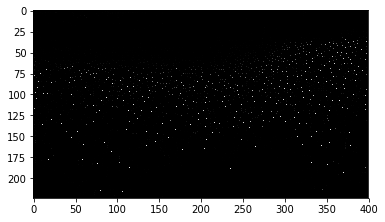

finish!!!


In [51]:
import cv2
import torch.nn as nn
def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel, kernel),
                                    stride=1,
                                    padding=pad)
    keep = (hmax == heat).float()
    return heat * keep


model.cuda()
model.eval()
img=cv2.imread('../worlds-largest-selfie.jpg')
wh=(int(img.shape[1]*1//16)*16,int(img.shape[0]*1//16)*16)
print(wh)
img=cv2.resize(img,wh)
img_ori=img.copy()
img=img[:,:,[2,1,0]].astype(np.float32)

h,w=img.shape[:2]
img=img/255
mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3).astype(np.float32)
std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3).astype(np.float32)

img=(img-mean)/std
img=img.transpose(2,0,1)
img=torch.tensor(img)
with torch.no_grad():
    img=img.cuda()
    img=img.unsqueeze(0)
    output=model(img)
def show_mask(output,img_ori):
    mask=output['hm'][0].permute(1,2,0).cpu().detach().numpy()
    mask=(255*(mask>0.05)*(mask<0.1)).astype(np.uint8)
    mask=cv2.resize(mask,wh)
#     mask=(255*((mask>0.02)*(mask<0.05))).astype(np.uint8)
#     mask=((mask<0.2)*255).astype(np.uint8)+((mask>0.5)*255).astype(np.uint8)
#     mask=cv2.resize(mask.copy(),wh)
    cv2.imwrite('mask.jpg',mask)
    input('s')
    
#     mask=mask.reshape(mask.shape[0],mask.shape[1],1)
    print(mask.shape)
    print(img_ori.shape)
    img_ori[mask>1]=0
    img=img_ori
    print(img.shape)
    plt.imshow(img)
    cv2.imwrite('mask1.jpg',img)
    print(mask.shape)
    print(wh)
    plt.show()
    input('s')
output['hm']=_nms(output['hm'])
output['hm_small']=_nms(output['hm_small'])
# show_mask(output,img_ori)
hm=output['hm']
# output['hm_small']=_nms(output['hm_small'])
output_=[output['hm'].cpu().detach().permute(0,2,3,1).numpy(),output['wh'].cpu().detach().permute(0,2,3,1).numpy(),output['offset'].cpu().detach().permute(0,2,3,1).numpy()]
output_small=[output['hm_small'].cpu().detach().permute(0,2,3,1).numpy(),output['wh_small'].cpu().detach().permute(0,2,3,1).numpy(),output['offset_small'].cpu().detach().permute(0,2,3,1).numpy()]
boxes = parse_wider_offset(output_small,h,w,
                                   score=0.05,
                                   nmsthre=0.8,down=2)
index = np.where(((boxes[:, 2] - boxes[:, 0] +
               1)*(boxes[:, 3] - boxes[:, 1] +
               1))**0.5<=20)[0]
boxes=boxes[index,:]
boxes2 = parse_wider_offset(output_,h,w,
                                   score=0.05,
                                   nmsthre=0.8,down=4)

# hm_small=output['hm_small'][0][0].cpu().detach().numpy()
# plt.imshow(hm_small)
# plt.show()
# input('s')
# boxes=parse_wider_offset(output_small,h,w,
#                                    score=0.05,down=1,nmsthre=0.8)
index = np.where(((boxes2[:, 2] - boxes2[:, 0] +
               1)*(boxes2[:, 3] - boxes2[:, 1] +
               1))**0.5>=16)[0]
boxes2 = boxes2[index, :]
boxes = np.row_stack((boxes2, boxes))
boxes = soft_bbox_vote(boxes, thre=0.4)
hm=output['hm'].cpu().detach()[0][0].numpy()
hm=(np.expand_dims(hm,-1).repeat(3,-1)*255).astype(np.uint8)
img1=vis_pred(img_ori.copy(),boxes[:1000])
cv2.imwrite('img1.jpg',img1)
img2=vis_pred(img_ori.copy(),boxes2[:600])
cv2.imwrite('img2.jpg',img2)
# hm=(np.expand_dims(hm,-1).repeat(3,-1)*255).astype(np.uint8)
plt.imshow(hm)
cv2.imwrite('pic2.jpg',hm)
# hm_small=(255-cv2.resize(hm_small,(wh))*255)
# hm_small=hm_small.reshape(hm_small.shape[0],hm_small.shape[1],1)
# img_ori=hm_small+img_ori

cv2.imwrite('pic_hm2.jpg',hm)
plt.show()
print('finish!!!')
# for data in val_loader:
#     with torch.no_grad():
#         out=model(data['input'].cuda())
#         plt.imshow(data['input'][0].permute(1,2,0))
#         plt.show()
#         plt.imshow(data['hm'][0][0])
#         cv2.imwrite('pic.jpg',data['hm'][0][0])
#         plt.show()
#         plt.imshow(out['hm'].cpu().detach()[0][0])
#         plt.show()
#         input('s')

In [147]:
import torch.nn.functional as F
class MaskLoss(torch.nn.Module):
    def __init__(self):
        super(MaskLoss, self).__init__()
        self.bce_loss = F.binary_cross_entropy

    def forward(self, output, label):
        cls_loss = self.bce_loss(output[:, 0, ...],
                                 label[:, 0, ...],
                                 reduction='none')
        positives = label[:, 0, :, :]
        negatives = label[:, 0, :, :].eq(0).float()
        foreground_weight = positives * ((1.0 - output[:, 0, :, :])**2)
        background_weight = negatives * (
            (1.0 - label[:, 0, :, :])**4.0) * (output[:, 0, :, :]**2)
#         focal_weight = foreground_weight + background_weight
        loss = torch.sum(foreground_weight * cls_loss)/torch.clamp(positives.sum(),1)+ torch.sum(background_weight * cls_loss)/torch.clamp(negatives.sum(),1)
        return loss

In [148]:
mask_loss=MaskLoss()

In [190]:
a=torch.zeros(1,1,704,704).float()
b=torch.zeros(1,1,704,704).float()
a[...]=0
a[:,:,400:410,400:410]=0.7
b[:,:,400:410,400:410]=1
mask_loss(a,b)

tensor(0.0321)

In [67]:
import os
import time
import pickle
from tqdm import tqdm
import os.path as osp
import cv2
import numpy as np
import torch

import torch.nn as nn
def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel, kernel),
                                    stride=1,
                                    padding=pad)
    keep = (hmax == heat).float()
    return heat * keep



def parse_wider_offset(Y,img_h_new,img_w_new, score=0.1, down=4, nmsthre=0.5):
    seman = Y[0][0, :, :, 0]
    height = Y[1][0, :, :, 0]
    width = Y[1][0, :, :, 1]
    offset_y = Y[2][0, :, :, 0]
    offset_x = Y[2][0, :, :, 1]
    y_c, x_c = np.where(seman > score)
    boxs = []
    if len(y_c) > 0:
        for i in range(len(y_c)):
            h = np.exp(height[y_c[i], x_c[i]]) * down
            w = np.exp(width[y_c[i], x_c[i]]) * down
            o_y = offset_y[y_c[i], x_c[i]]
            o_x = offset_x[y_c[i], x_c[i]]
            s = seman[y_c[i], x_c[i]]
            x1, y1 = max(0, (x_c[i] + o_x + 0.5) * down - w / 2), max(
                0, (y_c[i] + o_y + 0.5) * down - h / 2)
            x1, y1 = min(x1, img_w_new), min(y1, img_h_new)
            boxs.append([
                x1, y1,
                min(x1 + w, img_w_new),
                min(y1 + h, img_h_new), s
            ])
        boxs = np.asarray(boxs, dtype=np.float32)
        # keep = nms(boxs, nmsthre, usegpu=False, gpu_id=0)
        # boxs = boxs[keep, :]
        boxs = soft_bbox_vote(boxs, thre=nmsthre)
    return boxs


def soft_bbox_vote(det, thre=0.35, score=0.05):
    if det.shape[0] <= 1:
        return det
    order = det[:, 4].ravel().argsort()[::-1]
    det = det[order, :]
    dets = []
    while det.shape[0] > 0:
        # IOU
        area = (det[:, 2] - det[:, 0] + 1) * (det[:, 3] - det[:, 1] + 1)
        xx1 = np.maximum(det[0, 0], det[:, 0])
        yy1 = np.maximum(det[0, 1], det[:, 1])
        xx2 = np.minimum(det[0, 2], det[:, 2])
        yy2 = np.minimum(det[0, 3], det[:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        o = inter / (area[0] + area[:] - inter)

        # get needed merge det and delete these det
        merge_index = np.where(o >= thre)[0]
        det_accu = det[merge_index, :]
        det_accu_iou = o[merge_index]
        det = np.delete(det, merge_index, 0)

        if merge_index.shape[0] <= 1:
            try:
                dets = np.row_stack((dets, det_accu))
            except:
                dets = det_accu
            continue
        else:
            soft_det_accu = det_accu.copy()
            soft_det_accu[:, 4] = soft_det_accu[:, 4] * (1 - det_accu_iou)
            soft_index = np.where(soft_det_accu[:, 4] >= score)[0]
            soft_det_accu = soft_det_accu[soft_index, :]

            det_accu[:, 0:4] = det_accu[:, 0:4] * np.tile(
                det_accu[:, -1:], (1, 4))
            max_score = np.max(det_accu[:, 4])
            det_accu_sum = np.zeros((1, 5))
            det_accu_sum[:, 0:4] = np.sum(det_accu[:, 0:4], axis=0) / np.sum(
                det_accu[:, -1:])
            det_accu_sum[:, 4] = max_score

            if soft_det_accu.shape[0] > 0:
                det_accu_sum = np.row_stack((soft_det_accu, det_accu_sum))

            try:
                dets = np.row_stack((dets, det_accu_sum))
            except:
                dets = det_accu_sum

    order = dets[:, 4].ravel().argsort()[::-1]
    dets = dets[order, :]
    return dets





mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3).astype(np.float32)
std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3).astype(np.float32)

os.environ["CUDA_VISIBLE_DEVICES"] = '7'
cache_path = 'data/cache/widerface/val'
out_path = 'data/eval/resnet18_s1_conv4_conv2_imagenet_nms'
# pretrained_path = '/home/mayx/project/CenterNet/models/model_conv4_conv2_imagenet.pth'

# model = get_model(pretrained_path)
# model.cuda()
# model.eval()


img = cv2.imread('../worlds-largest-selfie.jpg')

def pre_process(img):

    img = img.astype(np.float32)
    img = img / 255
    img = img[..., [2, 1, 0]]
    img = (img - mean) / std
    img = torch.tensor(img).permute(2,0,1).unsqueeze(0)
    return img

def detect_face(img, scale=1, flip=False):
    img_h, img_w = img.shape[:2]
    img_h_new, img_w_new = int(np.ceil(scale * img_h / 16) * 16), int(
        np.ceil(scale * img_w / 16) * 16)
    scale_h, scale_w = img_h_new / img_h, img_w_new / img_w

    img_s = cv2.resize(img,
                       None,
                       None,
                       fx=scale_w,
                       fy=scale_h,
                       interpolation=cv2.INTER_LINEAR)
    # img_h, img_w = img_s.shape[:2]
    # print frame_number


    if flip:
        img_ = cv2.flip(img_s, 1)
        # x_rcnn = format_img_pad(img_sf, C)
        img = pre_process(img_)
    else:
        # x_rcnn = format_img_pad(img_s, C)
        img = pre_process(img_s)
    with torch.no_grad():
        output = model(img.cuda())
        output['hm']=_nms(output['hm'])
        output=[output['hm'].cpu().detach().permute(0,2,3,1).numpy(),output['wh'].cpu().detach().permute(0,2,3,1).numpy(),output['offset'].cpu().detach().permute(0,2,3,1).numpy()]
    boxes = parse_wider_offset(output,img_h_new,img_w_new,
                               score=0.05,
                               nmsthre=0.5)
    if len(boxes) > 0:
        keep_index = np.where(
            np.minimum(boxes[:, 2] - boxes[:, 0], boxes[:, 3] -
                       boxes[:, 1]) >= 12)[0]
        boxes = boxes[keep_index, :]
    if len(boxes) > 0:
        if flip:
            boxes[:, [0, 2]] = img_s.shape[1] - boxes[:, [2, 0]]
        boxes[:, 0:4:2] = boxes[:, 0:4:2] / scale_w
        boxes[:, 1:4:2] = boxes[:, 1:4:2] / scale_h
    else:
        boxes = np.empty(shape=[0, 5], dtype=np.float32)
    return boxes
def detect_face_small_normal(img, scale=1, flip=False,nms=False):
    img_h, img_w = img.shape[:2]
    img_h_new, img_w_new = int(np.ceil(scale * img_h / 16) * 16), int(
        np.ceil(scale * img_w / 16) * 16)
    scale_h, scale_w = img_h_new / img_h, img_w_new / img_w

    img_s = cv2.resize(img,
                       None,
                       None,
                       fx=scale_w,
                       fy=scale_h,
                       interpolation=cv2.INTER_LINEAR)
    # img_h, img_w = img_s.shape[:2]
    # print frame_number


    if flip:
        img_ = cv2.flip(img_s, 1)
        # x_rcnn = format_img_pad(img_sf, C)
        img = pre_process(img_)
    else:
        # x_rcnn = format_img_pad(img_s, C)
        img = pre_process(img_s)
    with torch.no_grad():
        output = model(img.cuda())
        if nms:
            output['hm']=_nms(output['hm'])
        if nms:
            output['hm_small']=_nms(output['hm_small'])
        output_s=[output['hm_small'].cpu().detach().permute(0,2,3,1).numpy(),output['wh_small'].cpu().detach().permute(0,2,3,1).numpy(),output['offset_small'].cpu().detach().permute(0,2,3,1).numpy()]
        output_n=[output['hm'].cpu().detach().permute(0,2,3,1).numpy(),output['wh'].cpu().detach().permute(0,2,3,1).numpy(),output['offset'].cpu().detach().permute(0,2,3,1).numpy()]

    boxes_s = parse_wider_offset(output_s,img_h_new,img_w_new,
                               score=0.05,
                               nmsthre=0.5,down=2)  
    boxes_n = parse_wider_offset(output_n,img_h_new,img_w_new,
                               score=0.05,
                               nmsthre=0.5)
    if len(boxes_s)>0:
        keep_index = np.where(
            np.minimum(boxes_s[:, 2] - boxes_s[:, 0], boxes_s[:, 3] -
                       boxes_s[:, 1])<=20)[0]
        boxes_s = boxes_s[keep_index, :]
    if len(boxes_n) > 0:
        keep_index = np.where(
            np.minimum(boxes_n[:, 2] - boxes_n[:, 0], boxes_n[:, 3] -
                       boxes_n[:, 1]) >= 16)[0]
        boxes_n = boxes_n[keep_index, :]
    boxes = np.row_stack((boxes_s, boxes_n))
    if len(boxes) > 0:
        if flip:
            boxes[:, [0, 2]] = img_s.shape[1] - boxes[:, [2, 0]]
        boxes[:, 0:4:2] = boxes[:, 0:4:2] / scale_w
        boxes[:, 1:4:2] = boxes[:, 1:4:2] / scale_h
    else:
        boxes = np.empty(shape=[0, 5], dtype=np.float32)
    return boxes
def im_det_ms_pyramid(image, max_im_shrink):
    # shrink detecting and shrink only detect big face
    det_s = np.row_stack(
        (detect_face(image, 0.5), detect_face(image, 0.5, flip=True)))
    index = np.where(
        np.maximum(det_s[:, 2] - det_s[:, 0] + 1, det_s[:, 3] -
                   det_s[:, 1] + 1) > 64)[0]
    det_s = det_s[index, :]

    det_temp = np.row_stack(
        (detect_face(image, 0.75), detect_face(image, 0.75, flip=True)))
    index = np.where(
        np.maximum(det_temp[:, 2] - det_temp[:, 0] + 1, det_temp[:, 3] -
                   det_temp[:, 1] + 1) > 32)[0]
    det_temp = det_temp[index, :]
    det_s = np.row_stack((det_s, det_temp))

    det_temp = np.row_stack(
        (detect_face(image, 0.25), detect_face(image, 0.25, flip=True)))
    index = np.where(
        np.maximum(det_temp[:, 2] - det_temp[:, 0] + 1, det_temp[:, 3] -
                   det_temp[:, 1] + 1) > 96)[0]
    det_temp = det_temp[index, :]
    det_s = np.row_stack((det_s, det_temp))

    st = [1.25, 1.5, 1.75, 2.0, 2.25]
    # st =[0.75,0.5,0.25] 
    for i in range(len(st)):
        if (st[i] <= max_im_shrink):
            det_temp = np.row_stack(
                (detect_face(image,
                             st[i]), detect_face(image, st[i], flip=True)))
            # Enlarged images are only used to detect small faces.
            if st[i] == 1.25:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 128)[0]
                det_temp = det_temp[index, :]
            elif st[i] == 1.5:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 96)[0]
                det_temp = det_temp[index, :]
            elif st[i] == 1.75:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 64)[0]
                det_temp = det_temp[index, :]
            elif st[i] == 2.0:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 48)[0]
                det_temp = det_temp[index, :]
            elif st[i] == 2.25:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 32)[0]
                det_temp = det_temp[index, :]
            elif st[i] == 0.25:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 64)[0]
                det_temp = det_temp[index, :]
            elif st[i] == 0.5:
                index = np.where(
                    np.minimum(det_temp[:, 2] - det_temp[:, 0] +
                               1, det_temp[:, 3] - det_temp[:, 1] +
                               1) < 128)[0]
                det_temp = det_temp[index, :]
            det_s = np.row_stack((det_s, det_temp))
    return det_s

max_im_shrink = (
    0x7fffffff / 577.0 /
    (img.shape[0] * img.shape[1]))**0.5  # the max size of input image
shrink = max_im_shrink if max_im_shrink < 1 else 1
det0 = detect_face_small_normal(img,nms=True)
#     det1 = detect_face(img, flip=True)
#     det2 = im_det_ms_pyramid(img, max_im_shrink)
# merge all test results via bounding box voting
#     det = np.row_stack((det0, det1, det2))
det=det0
keep_index = np.where(
    ((det[:, 2] - det[:, 0])*(det[:, 3] - det[:, 1]))**0.5 >= 2)[0]
# det = det[keep_index, :]
dets = soft_bbox_vote(det, thre=0.4)
# keep_index = np.where(
#     np.minimum(dets[:, 2] - dets[:, 0], dets[:, 3] - dets[:, 1]) >= 3)[0]
#     keep_index = np.where((dets[:, 2] - dets[:, 0] + 1) *
#                           (dets[:, 3] - dets[:, 1] + 1) >= 6**2)[0]
# dets = dets[keep_index, :]
img=cv2.imread('../worlds-largest-selfie.jpg')
img=vis_pred(img,dets[:1100])
cv2.imwrite('img.jpg',img)



True